## 0. Импорт библиотек

In [93]:
import optuna as optuna
import pandas as pd
import numpy as np
import random

In [94]:
pd.set_option('display.max_columns', None)

In [95]:
random.seed(41)
np.random.seed(41)

## 1. Загрузка данных

In [96]:
path_train = r"../data/train/"
path_test = r"../data/test/"

In [97]:
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').rename(columns={'plan_date': 'date'}).convert_dtypes()
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').rename(columns={'repdate': 'date'})
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').rename(columns={'rem_month': 'date'})
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet')
wag_param = pd.read_parquet(path_train + '/wag_params.parquet')
fr_info = pd.read_parquet(path_train + '/freight_info.parquet')
kti_izm = pd.read_parquet(path_train + '/kti_izm.parquet')
stations = pd.read_parquet(path_train + '/stations.parquet')

In [98]:
dislok_test = pd.read_parquet(path_test + '/dislok_wagons.parquet').rename(columns={'plan_date': 'date'}).convert_dtypes()
wag_prob_test = pd.read_parquet(path_test + '/wagons_probeg_ownersip.parquet').rename(columns={'repdate': 'date'})
pr_rem_test = pd.read_parquet(path_test + '/pr_rems.parquet').rename(columns={'rem_month': 'date'})
tr_rem_test = pd.read_parquet(path_test + '/tr_rems.parquet')
wag_param_test = pd.read_parquet(path_test + '/wag_params.parquet')
fr_info_test = pd.read_parquet(path_test + '/freight_info.parquet')
kti_izm_test = pd.read_parquet(path_test + '/kti_izm.parquet')
stations_test = pd.read_parquet(path_test + '/stations.parquet')

In [99]:
dislok = pd.concat([dislok, dislok_test])
wag_prob = pd.concat([wag_prob, wag_prob_test])
pr_rem = pd.concat([pr_rem, pr_rem_test])
tr_rem = pd.concat([tr_rem, tr_rem_test])
wag_param = pd.concat([wag_param, wag_param_test])
fr_info = pd.concat([fr_info, fr_info_test])
kti_izm = pd.concat([kti_izm, kti_izm_test])
stations = pd.concat([stations, stations_test])

In [100]:
del dislok_test
del wag_prob_test
del pr_rem_test
del tr_rem_test
del wag_param_test
del fr_info_test
del kti_izm_test
del stations_test

In [101]:
target = pd.read_csv(path_train + '/target/y_train.csv')
target_test = pd.read_csv(path_test + '/target/y_test.csv')
target = pd.concat([target, target_test])

### 1.1 Преобразование данных

Удалим неиспользуемые столбцы, добавим признак того, что вагон был на плановом ремонте (понадобится позже).

In [102]:
pr_rem['is_pr_rem'] = 1
dislok.drop(columns=['kod_vrab'], inplace=True)
pr_rem.drop(columns=['st_id_send', 'road_id_send', 'model'], inplace=True)

Объединим датасеты.

In [103]:
data = pd.merge(wag_prob, dislok, on=["date", "wagnum"])\
    .merge(pr_rem, on=["date", "wagnum", "rod_id", "month"], how='left')
data.rename(columns={'ost_prob_x': 'ost_prob'}, inplace=True)
data.drop(columns=['ost_prob_y'], inplace=True)
data.drop(columns=['distance_x'], inplace=True)
data.drop(columns=['distance_y'], inplace=True)

wag_param = wag_param.drop_duplicates(subset = 'wagnum')
data = pd.merge(data, wag_param, on=['wagnum', 'rod_id'], how='left')

Установим тип для категориальных признаков.

In [104]:
for prop in [
    'manage_type',
    'rod_id',
    'reestr_state',
    'ownership_type',
    'month',
    'kod_vrab',
    'id_road_disl',
    'st_id_dest',
    'id_road_dest',
    'st_id_send',
    'id_road_send',
    'fr_id',
    'last_fr_id',
    'road_id_rem',
    'st_id_rem',
    'ownertype',
    'model',
    'zavod_build',
    'kuzov',
    'telega',
    'tormoz',
    'tipvozd',
    'tippogl']:
    data[prop] = data[prop].astype('category')

data['ost_prob'].fillna(160000, inplace=True)

Для каждой даты заполним информацию о последнем плановом ремонте.

In [105]:
data.sort_values(by=['wagnum', 'date'], inplace=True)
data['last_pr_rem_date'] = None
data.loc[data['is_pr_rem'] == 1, 'last_pr_rem_date'] = data.loc[data['is_pr_rem'] == 1, 'date']
data.update(data.groupby(['wagnum'])[['road_id_rem', 'kod_vrab', 'st_id_rem', 'is_pr_rem', 'last_pr_rem_date']].ffill())

Заполним кол-во дней, прошедших после даты постройки вагона и кол-во дней до прогнозируемого планового ремонта.

In [106]:
data['days_since_build'] = (data['date'] - data['date_build']) / np.timedelta64(1, 'D')
data['days_until_pl_rem'] = (data['date_pl_rem'] - data['date']) / np.timedelta64(1, 'D')

Для каждой даты заполним, сколько раз проводился текущий ремонт после последнего планового ремонта.

In [107]:
tr_rem.rename(columns={'rem_month': 'date', 'kod_vrab': 'kod_vrab_tr'}, inplace=True)
tr_rem.drop(columns=['st_id_send', 'road_id_send', 'gr_probeg'], inplace=True)

In [108]:
data = pd.merge(data, tr_rem, on=['wagnum', 'date'], how='left')
for prop in [
    'kod_vrab_tr',
]:
    data[prop] = data[prop].astype('category')

In [109]:
# Пройти по всем записям. Увеличивать счетчик для каждого вагона и вида неисправности. Сбрасывать счетчики, когда меняется дата последнего ремонта или меняется вагон.
# data['neis1_kod_count'] = 0
# data['neis2_kod_count'] = 0
# data['neis3_kod_count'] = 0
#
# counter = {}
# prev_wag = -1
# prev_last_pr_rem_date = None
#
# def apply_callback(row):
#     global wagnum, prev_wag, last_pr_rem_date, prev_last_pr_rem_date, counter
#     wagnum = row['wagnum']
#     last_pr_rem_date = row['last_pr_rem_date']
#
#     res = {}
#     if wagnum != prev_wag or prev_last_pr_rem_date != last_pr_rem_date:
#         counter = {
#             'neis1_kod': 0,
#             'neis2_kod': 0,
#             'neis3_kod': 0,
#             # 'mod1_kod': 0,
#             # 'mod2_kod': 0,
#             # 'mod3_kod': 0,
#             # 'mod4_kod': 0,
#             # 'mod5_kod': 0,
#             # 'mod6_kod': 0,
#             # 'mod7_kod': 0,
#         }
#
#     if row['neis1_kod'] > 0:
#         counter['neis1_kod'] += 1
#
#     if row['neis2_kod'] > 0:
#         counter['neis2_kod'] += 1
#
#     if row['neis3_kod'] > 0:
#         counter['neis3_kod'] += 1
#
#     res['neis1_kod_count'] = counter['neis1_kod']
#     res['neis2_kod_count'] = counter['neis2_kod']
#     res['neis3_kod_count'] = counter['neis3_kod']
#
#     prev_wag = wagnum
#     prev_last_pr_rem_date = last_pr_rem_date
#
#     return res
#
# data[['neis1_kod_count', 'neis2_kod_count', 'neis3_kod_count']] = data.apply(lambda row: apply_callback(row), axis=1)

In [110]:
data['neis1_kod'].fillna(0, inplace=True)
data['neis2_kod'].fillna(0, inplace=True)
data['neis3_kod'].fillna(0, inplace=True)
data.loc[data['neis1_kod'] > 0, 'neis1_kod'] = 1
data.loc[data['neis2_kod'] > 0, 'neis2_kod'] = 1
data.loc[data['neis3_kod'] > 0, 'neis3_kod'] = 1
data.head(10)

,date,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month,date_kap,date_dep,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,isload,fr_id,last_fr_id,road_id_rem,kod_vrab,st_id_rem,is_pr_rem,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,last_pr_rem_date,days_since_build,days_until_pl_rem,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg
0,2022-08-01,0,82413,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10637.0,278.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
1,2022-08-02,0,81744,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10638.0,277.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
2,2022-08-03,0,81744,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10639.0,276.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
3,2022-08-04,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10640.0,275.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
4,2022-08-05,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10641.0,274.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
5,2022-08-06,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10642.0,273.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
6,2022-08-07,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10643.0,272.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
7,2022-08-08,0,80930,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,0,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10644.0,271.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
8,2022-08-09,0,80489,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,22,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10645.0,270.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>
9,2022-08-10,0,80489,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,22,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10646.0,269.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


In [111]:
data.update(data.groupby(['wagnum', 'last_pr_rem_date'], dropna=False)[['neis1_kod', 'neis2_kod', 'neis3_kod']].cumsum())

In [112]:
data['daily_prob'] = -data['ost_prob'].diff()
data.loc[data['daily_prob'] < 0, 'daily_prob'] = 0
data

,date,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month,date_kap,date_dep,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,isload,fr_id,last_fr_id,road_id_rem,kod_vrab,st_id_rem,is_pr_rem,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,last_pr_rem_date,days_since_build,days_until_pl_rem,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg,daily_prob
0,2022-08-01,0,82413,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10637.0,278.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
1,2022-08-02,0,81744,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10638.0,277.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,669
2,2022-08-03,0,81744,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10639.0,276.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0
3,2022-08-04,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10640.0,275.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,282
4,2022-08-05,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10641.0,274.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7220504,2023-02-24,33976,139271,0,1,1,0,2,2010-11-17,2020-08-02,2023-08-02,3,385,3,493,3,0,2255,1593,7.0,0.0,4387.0,1.0,12-532-02,700,700,77.0,235,1987-07-29,2033-08-29,0,NaT,110,160,2,9,2,1,12,160000,0,2022-10-28,12994.0,159.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2
7220505,2023-02-25,33976,138985,0,1,1,0,2,2010-11-17,2020-08-02,2023-08-02,3,385,3,493,3,0,2255,1593,7.0,0.0,4387.0,1.0,12-532-02,700,700,77.0,235,1987-07-29,2033-08-29,0,NaT,110,160,2,9,2,1,12,160000,0,2022-10-28,12995.0,158.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,286
7220506,2023-02-26,33976,138544,0,1,1,0,2,2010-11-17,2020-08-02,2023-08-02,3,385,3,493,3,0,2255,1593,7.0,0.0,4387.0,1.0,12-532-02,700,700,77.0,235,1987-07-29,2033-08-29,0,NaT,110,160,2,9,2,1,12,160000,0,2022-10-28,12996.0,157.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,441
7220507,2023-02-27,33976,138421,0,1,1,0,2,2010-11-17,2020-08-02,2023-08-02,3,22,3,385,3,0,2255,1593,7.0,0.0,4387.0,1.0,12-532-02,700,700,77.0,235,1987-07-29,2033-08-29,0,NaT,110,160,2,9,2,1,12,160000,0,2022-10-28,12997.0,156.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,123


In [113]:
data.sort_values(by=['wagnum', 'date'], inplace=True)
data['daily_prob_avg'] = data.groupby(['wagnum', 'month'])['daily_prob'].transform('mean')

## 2. EDA

In [23]:
data.head(10)

,date,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month,date_kap,date_dep,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,isload,fr_id,last_fr_id,road_id_rem,kod_vrab,st_id_rem,is_pr_rem,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,last_pr_rem_date,days_since_build,days_until_pl_rem,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg,daily_prob,daily_prob_avg
0,2022-08-01,0,82413,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10637.0,278.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,236.366667
1,2022-08-02,0,81744,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10638.0,277.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,669,236.366667
2,2022-08-03,0,81744,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10639.0,276.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,236.366667
3,2022-08-04,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10640.0,275.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,282,236.366667
4,2022-08-05,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10641.0,274.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,236.366667
5,2022-08-06,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10642.0,273.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,236.366667
6,2022-08-07,0,81462,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10643.0,272.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,236.366667
7,2022-08-08,0,80930,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,12202,44,11412,42,1,1671,0,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10644.0,271.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,532,236.366667
8,2022-08-09,0,80489,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,22,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10645.0,270.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,441,236.366667
9,2022-08-10,0,80489,0,0,1,0,8,2013-08-05,2020-05-06,2023-05-06,44,22,44,11412,42,1,1671,1671,NaN,NaN,NaN,NaN,11-276,680,680,122.0,244,1993-06-17,2025-12-03,1,NaT,110,160,2,9,2,1,11,160000,0,NaT,10646.0,269.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,236.366667


In [24]:
data_grouped = data.reset_index().groupby(["wagnum"])[["date"]].agg(["min", "max", "count"])
data_grouped.head()

date                 
              min        max count
wagnum                            
0      2022-08-01 2023-02-28   212
1      2022-08-01 2023-02-28   212
2      2022-08-01 2023-02-28   214
3      2022-08-01 2023-02-28   213
4      2022-08-01 2023-02-28   212

In [25]:
data_grouped.loc[:, data_grouped.columns.get_level_values(1) == 'count'].describe()

,date
,count
count,33977.000000
mean,212.511670
std,3.732181
min,41.000000
25%,212.000000
50%,213.000000
75%,213.000000
max,223.000000


In [26]:
pr_rem.sort_values(['date'])
pr_rem.head(10)

,wagnum,date,rod_id,road_id_rem,kod_vrab,st_id_rem,distance,month,is_pr_rem
0,15000,2022-08-05,1,3,0,493,37.0,8,1
2,25485,2022-08-21,1,13,0,4793,360.0,8,1
3,25944,2022-08-09,1,13,1,4793,322.0,8,1
4,24080,2022-08-13,1,13,0,4793,308.0,8,1
5,28612,2022-08-09,1,13,0,4793,373.0,8,1
6,30345,2022-08-07,1,13,1,4793,222.0,8,1
7,33346,2022-08-07,1,13,1,4793,218.0,8,1
8,4634,2022-08-10,0,13,0,4793,86.0,8,1
9,28731,2022-08-09,1,13,0,4793,379.0,8,1
10,29677,2022-08-06,1,13,1,4793,303.0,8,1


In [27]:
pr_rem[["wagnum", "month"]].groupby("wagnum").agg(["min", "max", "count"])

month          
         min max count
wagnum                
12        11  11     1
19         2   2     1
35         8   8     1
37        10  10     1
77        11  11     1
...      ...  ..   ...
33972     11  11     1
33973      9   9     1
33974     11  11     1
33975     10  10     1
33976     10  10     1

[11982 rows x 3 columns]

In [28]:
tr_rem[tr_rem['date'] > '2022-08-01'].head(20)

,wagnum,date,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg
0,29928,2022-09-01,3,0,98,54,7,4,2,0,0,0,0,38701
1,6039,2022-09-01,3,0,98,54,1,4,2,0,0,0,0,40292
2,6039,2022-09-01,3,2,62,51,7,4,2,0,0,0,0,40292
3,13674,2022-09-01,3,0,98,54,7,4,2,0,0,0,0,34845
4,13674,2022-09-01,3,6,98,54,7,4,2,0,0,0,0,34845
5,13674,2022-09-01,3,8,57,54,7,4,2,0,0,0,0,34848
6,21764,2022-09-01,3,2,98,54,7,4,2,0,0,0,0,53275
7,21764,2022-09-01,5,0,98,54,7,4,2,0,0,0,0,53395
8,1831,2022-09-01,3,19,95,54,7,4,2,0,0,0,0,2558
9,1831,2022-09-01,3,0,98,54,1,4,2,0,0,0,0,2558


In [29]:
data[data['is_pr_rem'] == 1]

,date,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month,date_kap,date_dep,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,isload,fr_id,last_fr_id,road_id_rem,kod_vrab,st_id_rem,is_pr_rem,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,last_pr_rem_date,days_since_build,days_until_pl_rem,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg,daily_prob,daily_prob_avg
2673,2022-11-22,12,22106,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,22,28,6408,28,0,2255,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10720.0,-10.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,13.433333
2674,2022-11-23,12,22106,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,4789,28,6408,28,0,5032,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10721.0,-11.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,13.433333
2675,2022-11-24,12,22085,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,4789,28,6408,28,0,5032,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10722.0,-12.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,21,13.433333
2676,2022-11-25,12,21703,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,22,28,4789,28,0,5032,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10723.0,-13.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,382,13.433333
2677,2022-11-26,12,21703,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,22,28,4789,28,0,5032,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10724.0,-14.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,13.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7220504,2023-02-24,33976,139271,0,1,1,0,2,2010-11-17,2020-08-02,2023-08-02,3,385,3,493,3,0,2255,1593,7.0,0.0,4387.0,1.0,12-532-02,700,700,77.0,235,1987-07-29,2033-08-29,0,NaT,110,160,2,9,2,1,12,160000,0,2022-10-28,12994.0,159.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2,134.75
7220505,2023-02-25,33976,138985,0,1,1,0,2,2010-11-17,2020-08-02,2023-08-02,3,385,3,493,3,0,2255,1593,7.0,0.0,4387.0,1.0,12-532-02,700,700,77.0,235,1987-07-29,2033-08-29,0,NaT,110,160,2,9,2,1,12,160000,0,2022-10-28,12995.0,158.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,286,134.75
7220506,2023-02-26,33976,138544,0,1,1,0,2,2010-11-17,2020-08-02,2023-08-02,3,385,3,493,3,0,2255,1593,7.0,0.0,4387.0,1.0,12-532-02,700,700,77.0,235,1987-07-29,2033-08-29,0,NaT,110,160,2,9,2,1,12,160000,0,2022-10-28,12996.0,157.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,441,134.75
7220507,2023-02-27,33976,138421,0,1,1,0,2,2010-11-17,2020-08-02,2023-08-02,3,22,3,385,3,0,2255,1593,7.0,0.0,4387.0,1.0,12-532-02,700,700,77.0,235,1987-07-29,2033-08-29,0,NaT,110,160,2,9,2,1,12,160000,0,2022-10-28,12997.0,156.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,123,134.75


In [30]:
data_1071 = data[data['wagnum'] == 1071]
data_1072 = data[data['wagnum'] == 1072]
data_7176 = data[data['wagnum'] == 7176]
data_12 = data[data['wagnum'] == 12]

In [31]:
data_1071.head()

,date,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month,date_kap,date_dep,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,isload,fr_id,last_fr_id,road_id_rem,kod_vrab,st_id_rem,is_pr_rem,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,last_pr_rem_date,days_since_build,days_until_pl_rem,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg,daily_prob,daily_prob_avg
227525,2022-08-01,1071,36899,0,0,1,0,8,NaT,2020-02-16,2023-02-16,42,22,42,11470,42,0,5032,1413,NaN,NaN,NaN,NaN,11-1807-01,667,667,165.0,271,2013-09-19,2044-11-21,17,NaT,110,160,2,9,2,7,16,160000,0,NaT,3238.0,199.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,25457,916.870968
227526,2022-08-02,1071,36899,0,0,1,0,8,NaT,2020-02-16,2023-02-16,42,11663,0,11470,42,1,1204,1204,NaN,NaN,NaN,NaN,11-1807-01,667,667,165.0,271,2013-09-19,2044-11-21,17,NaT,110,160,2,9,2,7,16,160000,0,NaT,3239.0,198.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,916.870968
227527,2022-08-03,1071,36711,0,0,1,0,8,NaT,2020-02-16,2023-02-16,42,11663,0,11470,42,1,1204,1204,NaN,NaN,NaN,NaN,11-1807-01,667,667,165.0,271,2013-09-19,2044-11-21,17,NaT,110,160,2,9,2,7,16,160000,0,NaT,3240.0,197.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,188,916.870968
227528,2022-08-04,1071,36711,0,0,1,0,8,NaT,2020-02-16,2023-02-16,42,11663,0,11470,42,1,1204,1204,NaN,NaN,NaN,NaN,11-1807-01,667,667,165.0,271,2013-09-19,2044-11-21,17,NaT,110,160,2,9,2,7,16,160000,0,NaT,3241.0,196.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,916.870968
227529,2022-08-05,1071,36711,0,0,1,0,8,NaT,2020-02-16,2023-02-16,42,11663,0,11470,42,1,1204,1204,NaN,NaN,NaN,NaN,11-1807-01,667,667,165.0,271,2013-09-19,2044-11-21,17,NaT,110,160,2,9,2,7,16,160000,0,NaT,3242.0,195.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,916.870968


In [32]:
data_12.head(200)

,date,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month,date_kap,date_dep,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,isload,fr_id,last_fr_id,road_id_rem,kod_vrab,st_id_rem,is_pr_rem,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,last_pr_rem_date,days_since_build,days_until_pl_rem,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg,daily_prob,daily_prob_avg
2559,2022-08-01,12,27576,0,0,1,0,8,2011-05-30,2019-11-12,2022-11-12,15,22,15,3748,15,0,2255,5012,NaN,NaN,NaN,NaN,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,NaT,10607.0,103.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,42950,1400.258065
2560,2022-08-02,12,27576,0,0,1,0,8,2011-05-30,2019-11-12,2022-11-12,15,22,15,3748,15,0,2255,5012,NaN,NaN,NaN,NaN,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,NaT,10608.0,102.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,1400.258065
2561,2022-08-03,12,27576,0,0,1,0,8,2011-05-30,2019-11-12,2022-11-12,15,22,15,3748,15,0,2255,5012,NaN,NaN,NaN,NaN,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,NaT,10609.0,101.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,1400.258065
2562,2022-08-04,12,27576,0,0,1,0,8,2011-05-30,2019-11-12,2022-11-12,15,22,15,3748,15,0,2255,5012,NaN,NaN,NaN,NaN,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,NaT,10610.0,100.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,1400.258065
2563,2022-08-05,12,27576,0,0,1,0,8,2011-05-30,2019-11-12,2022-11-12,15,22,15,3748,15,0,2255,5012,NaN,NaN,NaN,NaN,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,NaT,10611.0,99.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,1400.258065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,2023-02-11,12,104479,0,0,1,0,2,2011-05-30,2019-11-12,2022-11-12,25,22,25,5234,25,1,1485,1485,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10801.0,-91.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,37.321429
2755,2023-02-12,12,104479,0,0,1,0,2,2011-05-30,2019-11-12,2022-11-12,25,22,25,5234,25,1,1485,1485,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10802.0,-92.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,37.321429
2756,2023-02-13,12,104479,0,0,1,0,2,2011-05-30,2019-11-12,2022-11-12,25,22,25,5234,25,1,1485,1485,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10803.0,-93.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,37.321429
2757,2023-02-14,12,104479,0,0,1,0,2,2011-05-30,2019-11-12,2022-11-12,25,22,25,5234,25,1,1485,1485,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10804.0,-94.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,37.321429


In [33]:
data_12[data_12['is_pr_rem'] == 1]

,date,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month,date_kap,date_dep,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,isload,fr_id,last_fr_id,road_id_rem,kod_vrab,st_id_rem,is_pr_rem,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,last_pr_rem_date,days_since_build,days_until_pl_rem,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg,daily_prob,daily_prob_avg
2673,2022-11-22,12,22106,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,22,28,6408,28,0,2255,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10720.0,-10.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,13.433333
2674,2022-11-23,12,22106,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,4789,28,6408,28,0,5032,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10721.0,-11.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,13.433333
2675,2022-11-24,12,22085,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,4789,28,6408,28,0,5032,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10722.0,-12.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,21,13.433333
2676,2022-11-25,12,21703,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,22,28,4789,28,0,5032,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10723.0,-13.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,382,13.433333
2677,2022-11-26,12,21703,0,0,1,0,11,2011-05-30,2019-11-12,2022-11-12,28,22,28,4789,28,0,5032,5012,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10724.0,-14.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,13.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,2023-02-24,12,104479,0,0,1,0,2,2011-05-30,2019-11-12,2022-11-12,25,22,25,5234,25,1,1485,1485,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10814.0,-104.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,37.321429
2768,2023-02-25,12,104479,0,0,1,0,2,2011-05-30,2019-11-12,2022-11-12,25,22,25,5234,25,1,1485,1485,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10815.0,-105.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,37.321429
2769,2023-02-26,12,104479,0,0,1,0,2,2011-05-30,2019-11-12,2022-11-12,25,22,25,5234,25,1,1485,1485,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10816.0,-106.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,37.321429
2770,2023-02-27,12,104479,0,0,1,0,2,2011-05-30,2019-11-12,2022-11-12,25,22,25,5234,25,1,1485,1485,13.0,0.0,6408.0,1.0,11-270,688,688,122.0,240,1993-07-17,2024-06-04,1,NaT,110,160,2,9,2,1,2,110000,0,2022-11-22,10817.0,-107.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,0,37.321429


<AxesSubplot: xlabel='date'>

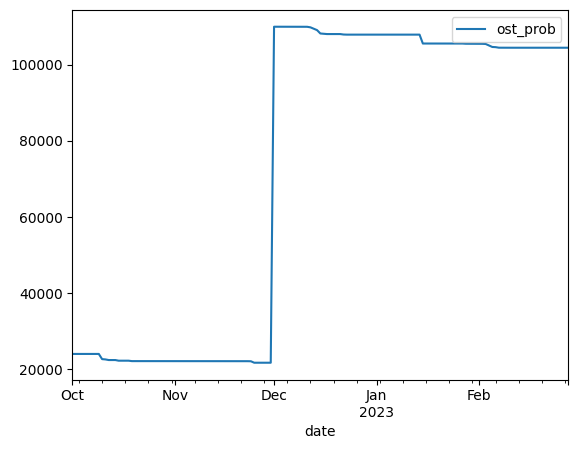

In [34]:
data_12[data_12['date'] >= '2022-10-01'].plot(x="date", y="ost_prob")

In [35]:
target[target['wagnum'] == 12]

,wagnum,month,target_month,target_day
24143,12,2023-01-01,0,0
58119,12,2022-08-01,0,0
92094,12,2022-09-01,0,0
126070,12,2022-10-01,0,0
160046,12,2022-11-01,1,0
194022,12,2022-12-01,0,0
23929,12,2023-02-01,0,0


In [36]:
data_1071[data_1071['date'] == '2023-01-24']['ost_prob']

227701    3978
Name: ost_prob, dtype: Int64

<AxesSubplot: >

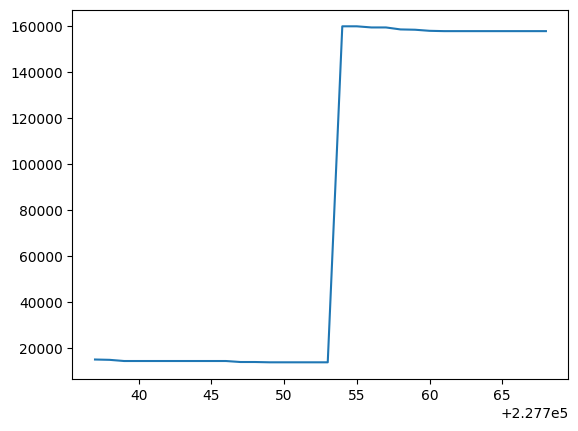

In [37]:
data_1072[data_1072['date'] <= '2022-09-01']['ost_prob'].plot()

In [38]:
data_1072[data_1072['date'] == '2022-08-18']['ost_prob']

227754    160000
Name: ost_prob, dtype: Int64

In [39]:
wag_param.head(10)

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
3218,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,160,160,2,9,3,6,11,110000,0
19128,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,110,160,2,9,2,1,12,0,0
21526,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,110,160,2,9,2,1,1,160000,1
32353,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,250,500,2,11,2,7,12,250000,1
81,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,110,160,2,9,2,1,11,160000,1
108,16521,11-270,0,688,688,122.0,240,1993-07-07,2025-05-06,1,NaT,110,160,2,9,2,1,11,110000,0
228,6387,11-276,0,680,680,122.0,260,1991-06-30,2025-03-05,1,NaT,110,160,2,9,3,1,1,0,0
244,6592,11-280,0,680,680,138.0,260,1991-12-25,2025-06-27,1,NaT,110,160,2,9,2,1,11,110000,1
253,16484,11-270,0,688,688,122.0,240,1994-01-12,2023-04-28,1,NaT,110,160,2,9,2,1,2,160000,1
384,7000,11-280,0,680,680,138.0,260,1993-05-20,2026-10-02,1,NaT,110,160,2,9,2,1,1,160000,1


In [40]:
target.head(10)

,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0
5,33354,2023-01-01,0,0
6,33355,2023-01-01,0,0
7,33356,2023-01-01,0,0
8,33370,2023-01-01,0,0
9,33373,2023-01-01,0,0


In [41]:
target[["wagnum", "month"]].groupby("wagnum").agg(["min", "max", "count"])

month                  
               min         max count
wagnum                              
0       2022-08-01  2023-02-01     7
1       2022-08-01  2023-02-01     7
2       2022-08-01  2023-02-01     7
3       2022-08-01  2023-02-01     7
4       2022-08-01  2023-02-01     7
...            ...         ...   ...
33972   2022-08-01  2023-02-01     7
33973   2022-08-01  2023-02-01     7
33974   2022-08-01  2023-02-01     7
33975   2022-08-01  2023-02-01     7
33976   2022-08-01  2023-02-01     7

[33977 rows x 3 columns]

In [42]:
tr_rem.head(10)

,wagnum,date,kod_vrab_tr,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,por_probeg
0,29938,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,37467
1,29938,2022-08-01,3,14,98,54,7,4,2,0,0,0,0,37467
2,29852,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,45579
3,29852,2022-08-01,2,36,98,54,7,4,2,0,0,0,0,45579
4,13674,2022-08-01,2,95,98,54,7,4,2,0,0,0,0,34697
5,13674,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,34697
6,1145,2022-08-01,3,2,98,54,7,4,2,0,0,0,0,39549
7,1145,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,39549
8,2430,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,26528
9,2430,2022-08-01,3,2,98,54,7,4,2,0,0,0,0,26528


In [43]:
tr_rem[["wagnum", "rem_month"]].groupby("wagnum").agg(["min", "max", "count"])

KeyError: "['rem_month'] not in index"

In [ ]:
tr_rem['kod_vrab_tr'].unique()

In [ ]:
tr_rem['mod7_kod'].unique()

In [ ]:
pr_rem['kod_vrab'].unique()

In [ ]:
kti_izm.head(20)

In [ ]:
kti_izm[["wagnum", "operation_date_dttm", "mileage_all"]].groupby(["wagnum", "operation_date_dttm"]).count()

In [ ]:
kti_izm[["wagnum", "operation_date_dttm", "mileage_all"]].groupby(["wagnum", "operation_date_dttm"]).count()["mileage_all"].max()

## 4. Обучение

In [114]:
data.columns

Index(['date', 'wagnum', 'ost_prob', 'manage_type', 'rod_id', 'reestr_state',
       'ownership_type', 'month', 'date_kap', 'date_dep', 'date_pl_rem',
       'id_road_disl', 'st_id_dest', 'id_road_dest', 'st_id_send',
       'id_road_send', 'isload', 'fr_id', 'last_fr_id', 'road_id_rem',
       'kod_vrab', 'st_id_rem', 'is_pr_rem', 'model', 'gruz',
       'cnsi_gruz_capacity', 'cnsi_volumek', 'tara', 'date_build', 'srok_sl',
       'zavod_build', 'date_iskl', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov',
       'telega', 'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype',
       'last_pr_rem_date', 'days_since_build', 'days_until_pl_rem',
       'kod_vrab_tr', 'neis1_kod', 'neis2_kod', 'neis3_kod', 'mod1_kod',
       'mod2_kod', 'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod', 'mod7_kod',
       'por_probeg', 'daily_prob', 'daily_prob_avg'],
      dtype='object')

In [115]:
columns = ['date', 'wagnum', 'ost_prob', 'manage_type', 'rod_id', 'reestr_state',
           'ownership_type', 'month', 'kod_vrab', 'is_pr_rem', 'model', 'gruz',
           'cnsi_gruz_capacity', 'cnsi_volumek', 'tara', 'srok_sl',
           'zavod_build', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov',
           'telega', 'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype', 'neis1_kod',
                  'neis2_kod', 'neis3_kod', 'days_since_build', 'days_until_pl_rem', 'daily_prob_avg', ]
columns_X = ['ost_prob', 'manage_type', 'rod_id', 'reestr_state',
           'ownership_type', 'month', 'kod_vrab', 'is_pr_rem', 'model', 'gruz',
           'cnsi_gruz_capacity', 'cnsi_volumek', 'tara',
           'zavod_build', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov',
           'telega', 'tormoz', 'tipvozd', 'tippogl', 'norma_km', 'ownertype', 'neis1_kod',
                  'neis2_kod', 'neis3_kod', 'days_since_build', 'days_until_pl_rem', 'daily_prob_avg', ]

Подготовим данные для обучения и валидации модели.

In [116]:
def fill_category_column_na(col):
    col = col.cat.add_categories(-1)
    col = col.fillna(-1)
    return col

In [ ]:
data_preprocessed = data[columns]
data_preprocessed['kod_vrab'] = data_preprocessed['kod_vrab'].astype('category')
data_preprocessed['kod_vrab'] = fill_category_column_na(data_preprocessed['kod_vrab'])
data_preprocessed['tippogl'] = fill_category_column_na(data_preprocessed['tippogl'])
data_preprocessed['is_pr_rem'] = data_preprocessed['is_pr_rem'].fillna(0)
data_preprocessed.head(10)

In [118]:
month_to_predict = pd.to_datetime('2022-12-01')

In [119]:
target.month = pd.to_datetime(target.month)
target['month'] = target['month']

In [120]:
data_with_target = target.rename(columns={"month": "date"}).merge(data_preprocessed, left_on=['wagnum', 'date'], right_on=['wagnum', 'date'], how='inner')

In [121]:
data_for_train = data_with_target[data_with_target['date'] <= month_to_predict].convert_dtypes()
data_for_test = data_with_target[data_with_target['date'] > month_to_predict].convert_dtypes()

In [122]:
data_for_train.isna().any()

wagnum                False
date                  False
target_month          False
target_day            False
ost_prob              False
manage_type           False
rod_id                False
reestr_state          False
ownership_type        False
month                 False
kod_vrab              False
is_pr_rem             False
model                 False
gruz                  False
cnsi_gruz_capacity    False
cnsi_volumek          False
tara                  False
srok_sl               False
zavod_build           False
cnsi_probeg_dr        False
cnsi_probeg_kr        False
kuzov                 False
telega                False
tormoz                False
tipvozd               False
tippogl               False
norma_km              False
ownertype             False
neis1_kod             False
neis2_kod             False
neis3_kod             False
days_since_build      False
days_until_pl_rem     False
daily_prob_avg        False
dtype: bool

In [123]:
for t in ['wagnum', 'target_month', 'target_day', 'ost_prob', 'is_pr_rem', 'gruz', 'tara']:
    data_for_train[t] = data_for_train[t].astype(int)

Создадим пайплайн обучения модели. Будем решать задачу классификации с 2 целевыми переменными - target_month, target_day.

In [124]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include='category')
categorical_columns = categorical_columns_selector(data_with_target)
categorical_columns

['manage_type',
 'rod_id',
 'reestr_state',
 'ownership_type',
 'month',
 'kod_vrab',
 'model',
 'zavod_build',
 'kuzov',
 'telega',
 'tormoz',
 'tipvozd',
 'tippogl',
 'ownertype']

In [125]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

Подберем гиперпараметры с помощью библиотеки Optuna.

In [138]:
from metrics_f1 import calc_f1_score_from_data
import optuna

def objective(trial):
    categorical_preprocessor = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )
    preprocessor = ColumnTransformer(
        [("categorical", categorical_preprocessor, categorical_columns)],
        remainder="passthrough",
    )

    params = {
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10, 10.0, log=True),
        'early_stopping': trial.suggest_categorical('early_stopping', ['auto', False]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'max_iter': trial.suggest_int("max_iter", 20, 200),
        # 'max_depth': trial.suggest_int('max_depth', 2, 30),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 100000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 80),
    }
    model1 = make_pipeline(preprocessor, HistGradientBoostingClassifier(**params))
    model2 = make_pipeline(preprocessor, HistGradientBoostingClassifier(**params))

    _ = model1.fit(data_for_train[columns_X], data_for_train['target_month'].astype(int))
    _ = model2.fit(data_for_train[columns_X], data_for_train['target_day'].astype(int))

    y_pred_1 = model1.predict(data_for_test[columns_X])
    y_pred_2 = model2.predict(data_for_test[columns_X])
    true = data_for_test[['target_month', 'target_day']]
    pred = pd.DataFrame({'target_month': y_pred_1, 'target_day': y_pred_2})

    true_path = '../data/test/prediction/target_predicton_true.csv'
    pred_path = '../data/test/prediction/target_predicton.csv'

    true.to_csv(true_path, index=False)
    pred.to_csv(pred_path, index=False)

    return calc_f1_score_from_files(true_path, pred_path)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2023-11-12 06:14:09,148] A new study created in memory with name: no-name-7cd7d54e-c7f9-45f1-b4a6-2805a79b8ad1
[I 2023-11-12 06:14:14,511] Trial 0 finished with value: 0.0 and parameters: {'l2_regularization': 0.008205715236801693, 'early_stopping': False, 'learning_rate': 0.0628322394592398, 'max_iter': 121, 'max_bins': 153, 'min_samples_leaf': 47689, 'max_leaf_nodes': 41}. Best is trial 0 with value: 0.0.
[I 2023-11-12 06:14:26,102] Trial 1 finished with value: 0.24017302990408126 and parameters: {'l2_regularization': 0.2924539143608978, 'early_stopping': False, 'learning_rate': 0.00835035222067932, 'max_iter': 191, 'max_bins': 108, 'min_samples_leaf': 661, 'max_leaf_nodes': 73}. Best is trial 1 with value: 0.24017302990408126.
[I 2023-11-12 06:14:29,581] Trial 2 finished with value: 0.0 and parameters: {'l2_regularization': 1.3666337617716134e-10, 'early_stopping': 'auto', 'learning_rate': 0.01582424043895958, 'max_iter': 42, 'max_bins': 214, 'min_samples_leaf': 43165, 'max_leaf_

FrozenTrial(number=80, state=TrialState.COMPLETE, values=[0.5069457723471912], datetime_start=datetime.datetime(2023, 11, 12, 6, 23, 20, 607335), datetime_complete=datetime.datetime(2023, 11, 12, 6, 23, 33, 621536), params={'l2_regularization': 0.08054497027132228, 'early_stopping': 'auto', 'learning_rate': 0.05698460206866761, 'max_iter': 174, 'max_bins': 225, 'min_samples_leaf': 334, 'max_leaf_nodes': 63}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'l2_regularization': FloatDistribution(high=10.0, log=True, low=1e-10, step=None), 'early_stopping': CategoricalDistribution(choices=('auto', False)), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'max_iter': IntDistribution(high=200, log=False, low=20, step=1), 'max_bins': IntDistribution(high=255, log=False, low=100, step=1), 'min_samples_leaf': IntDistribution(high=100000, log=False, low=20, step=1), 'max_leaf_nodes': IntDistribution(high=80, log=False, low=20, step=1)}, trial_

In [139]:
categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

preprocessor = ColumnTransformer(
    [("categorical", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

model1 = make_pipeline(preprocessor, HistGradientBoostingClassifier(**{'l2_regularization': 0.08054497027132228, 'early_stopping': 'auto', 'learning_rate': 0.05698460206866761, 'max_iter': 174, 'max_bins': 225, 'min_samples_leaf': 334, 'max_leaf_nodes': 63}))
model2 = make_pipeline(preprocessor, HistGradientBoostingClassifier(**{'l2_regularization': 0.08054497027132228, 'early_stopping': 'auto', 'learning_rate': 0.05698460206866761, 'max_iter': 174, 'max_bins': 225, 'min_samples_leaf': 334, 'max_leaf_nodes': 63}))

_ = model1.fit(data_for_train[columns_X], data_for_train['target_month'].astype(int))
_ = model2.fit(data_for_train[columns_X], data_for_train['target_month'].astype(int))

## 5. Валидация на тестовой выборке

In [140]:
data_for_test[:10]

,wagnum,date,target_month,target_day,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month,kod_vrab,is_pr_rem,model,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,srok_sl,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,neis1_kod,neis2_kod,neis3_kod,days_since_build,days_until_pl_rem,daily_prob_avg
0,33361,2023-01-01,0,0,153113,0,1,1,0,1,0.0,1,12-1303-01,690,690,88.0,245,2033-03-01,6,110,160,2,2,2,3,11,160000,0,0,0,0,4345,47,88.096774
1,33364,2023-01-01,0,0,157426,0,1,1,0,1,0.0,1,12-1303-01,690,690,88.0,245,2031-04-12,6,110,160,2,2,2,3,11,160000,0,0,0,0,4638,275,290.516129
2,33366,2023-01-01,0,0,159748,0,1,1,0,1,1.0,1,12-1303-01,690,690,88.0,245,2032-01-21,6,110,160,2,2,2,3,11,160000,0,0,0,0,4575,92,161.548387
3,33358,2023-01-01,0,0,28597,0,1,1,0,1,-1.0,0,12-1303-01,690,690,88.0,245,2032-11-30,6,110,160,2,2,2,3,11,160000,0,1,2,2,3748,418,120.580645
4,33349,2023-01-01,0,0,150043,0,1,1,0,1,0.0,1,12-1303-01,690,690,88.0,245,2033-12-04,6,110,160,2,2,2,6,11,160000,0,0,0,0,4060,186,188.225806
5,33354,2023-01-01,0,0,15237,0,1,1,0,1,-1.0,0,12-1303-01,690,690,88.0,245,2031-03-24,6,110,160,2,2,2,6,11,160000,0,0,0,0,4427,209,95.322581
6,33355,2023-01-01,0,0,8730,0,1,1,0,1,-1.0,0,12-1303-01,690,690,88.0,245,2031-12-17,6,110,160,2,2,2,7,11,160000,0,1,2,2,4323,378,156.580645
7,33356,2023-01-01,0,0,141461,0,1,1,0,1,1.0,1,12-1303-01,690,690,88.0,245,2033-11-17,6,110,160,2,2,2,7,11,160000,0,0,0,0,3920,-95,121.387097
8,33370,2023-01-01,0,0,152431,0,1,1,0,1,0.0,1,12-1303-01,690,690,88.0,245,2032-08-28,6,110,160,2,2,2,3,11,160000,0,0,0,0,4257,184,337.258065
9,33373,2023-01-01,0,0,343038,1,1,1,0,1,0.0,1,12-196-02,750,750,94.0,247,2050-02-12,0,350,500,43,11,2,7,11,350000,1,0,0,0,1760,78,285.870968


In [141]:
y_true_1, y_true_2 = data_for_test['target_month'], data_for_test['target_day']

In [142]:
y_pred_1 = model1.predict(data_for_test[columns_X])
y_pred_2 = model2.predict(data_for_test[columns_X])

In [143]:
true_path = '../data/test/prediction/target_predicton_true.csv'
pred_path = '../data/test/prediction/target_predicton.csv'

In [144]:
true = data_for_test[['target_month', 'target_day']]
true.to_csv(true_path, index=False)

pred = pd.DataFrame({'target_month': y_pred_1, 'target_day': y_pred_2})
pred.to_csv(pred_path, index=False)

Оценим, насколько хорошо удалось предсказать выбытие вагонов по месяцу и по 10 дням.

In [145]:
from metrics_f1 import calc_f1_score_from_files

calc_f1_score_from_files(true_path, pred_path)

0.5117530314572787

## 6. Подготовка результатов для сабмита

In [146]:
submit_path = '../data/test/prediction/target_prediction_submit.csv'

In [147]:
for_submit = pd.read_csv(path_test + '/target/y_predict.csv').convert_dtypes()
for_submit.month = pd.to_datetime(for_submit.month)
for_submit.rename(columns={"month": "date"}, inplace=True)
for_submit.head(10)

,wagnum,date
0,33361,2023-03-01
1,33364,2023-03-01
2,33366,2023-03-01
3,33358,2023-03-01
4,33349,2023-03-01
5,33354,2023-03-01
6,33355,2023-03-01
7,33356,2023-03-01
8,33370,2023-03-01
9,33373,2023-03-01


In [148]:
for_submit['date'] = for_submit['date'] - pd.DateOffset(1)
data_for_submit = for_submit.merge(data_preprocessed, on=['wagnum', 'date'], how='left').ffill()
y_pred_1 = model1.predict(data_for_submit)
y_pred_2 = model2.predict(data_for_submit)
data_for_submit['target_month'] = y_pred_1
data_for_submit['target_day'] = y_pred_2
data_for_submit['date'] = data_for_submit['date'] + pd.DateOffset(1)
data_for_submit = data_for_submit[['wagnum', 'date', 'target_month', 'target_day']].rename(columns={"date": "month"})
data_for_submit.to_csv(submit_path, index=False)